In [137]:
import matplotlib.pyplot as plt
from module.utils import *
import pytransform3d.rotations as pr

# Create Groundtruth matrix

## Define Parameters

In [138]:
# rotate an angle of pi/4 along the standard Y axis
angles = [np.pi]
order = 'z'

# translate by the given offset
offset = np.array([5, 4, 0.6])

# define intrinsic parameters
# -------------------------------

f = 0.6  # focal length
s = 0  # skew
a = 1  # aspect ratio
cx = 5  # principal point x
cy = 4  # principal point y
img_size = (10, 10)  # image size

## Create Extrinsic and Intrinsic Matrix

In [139]:
# create extrinsic matrix
# --------------------------

# create rotation transformation matrix
R = create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation transformation matrix
T_ = create_translation_matrix(offset)

E = np.linalg.inv(T_ @ R_)
E = E[:-1, :]

# create intrinsic matrix
# ---------------------------
K = compute_intrinsic_parameter_matrix(f, s, a, cx, cy)

In [140]:
R_

array([[-1.0000000e+00, -1.2246468e-16,  0.0000000e+00,  0.0000000e+00],
       [ 1.2246468e-16, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

## generate random points

In [141]:
# choose the lower limit of the points such they're always beyond the image plane
# n_points = 4
# rand_points = generate_random_points(n_points, (-4, 0), (-4, 4), (f, 4))

In [142]:
n_points = 4
z = [14, 14, 3, 3]
y = [-4, 11, 11, -4]
x = [0, 0, 0, 0]

rand_points = np.vstack((x, y, z))

## Plot the setup

In [143]:
# create an image grid
xx, yy, Z = create_image_grid(f, img_size)
# convert the image grid to homogeneous coordinates
pt_h = convert_grid_to_homogeneous(xx, yy, Z, img_size)
# transform the homogeneous coordinates
pt_h_transformed = T_ @ R_ @ pt_h
# convert the transformed homogeneous coordinates back to the image grid
xxt, yyt, Zt = convert_homogeneous_to_grid(pt_h_transformed, img_size)

Text(0.5, 0, 'Z-axis')

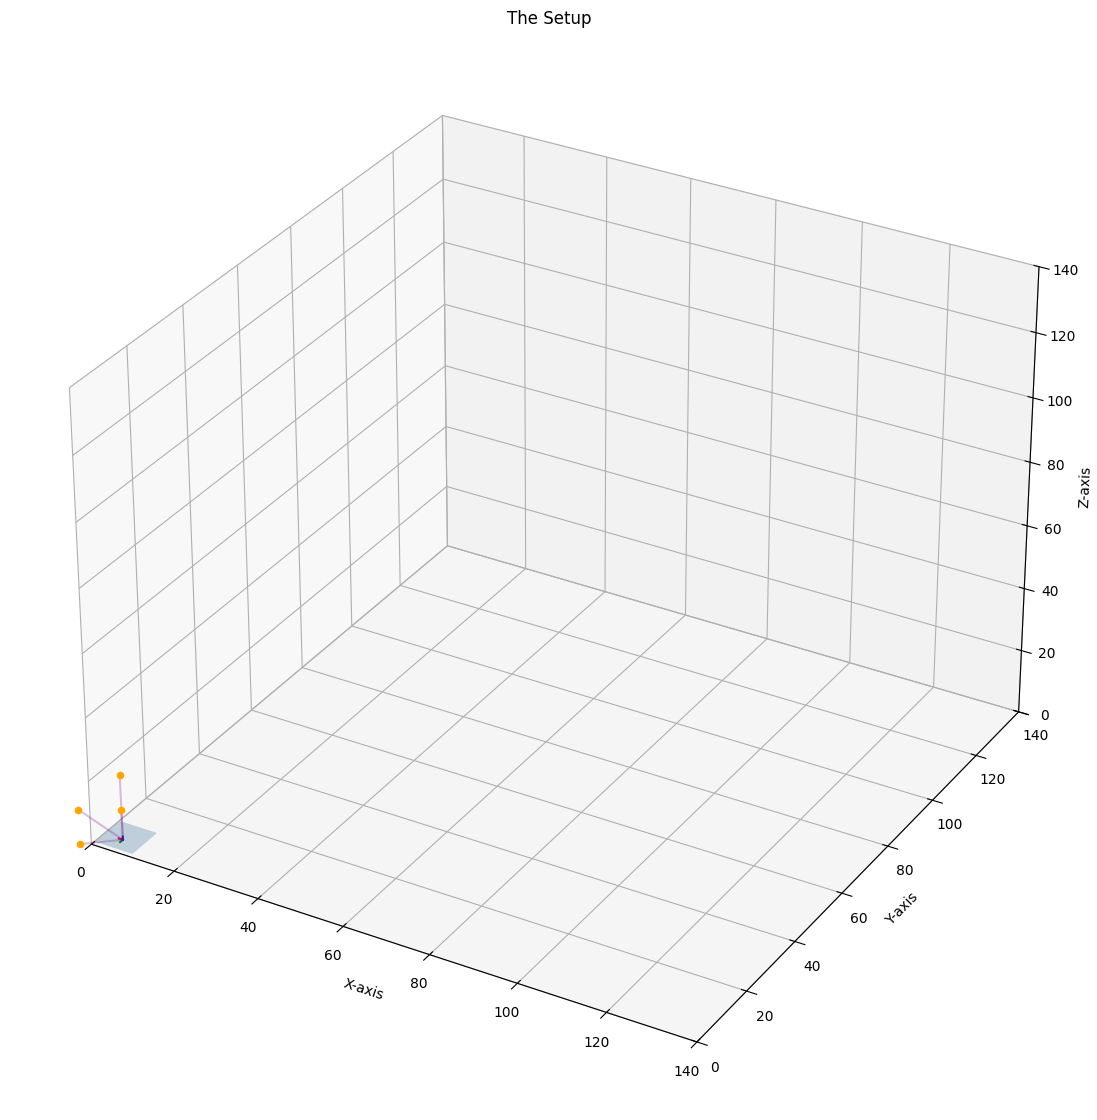

In [144]:
rec = 140
# define axis and figure
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111,projection='3d')  # 111 is nrows, ncols, index

# set limits
ax.set(xlim=(0, rec), ylim=(0, rec), zlim=(0, rec))

# plot the camera in the world
ax = pr.plot_basis(ax, R, offset)
ax.plot_surface(xxt, yyt, Zt, alpha=0.25)

# plot the generated random points
c = 0
for i in range(n_points):
    point = rand_points[:, c]
    ax.scatter(*point, color="orange")
    ax.plot(*make_line(offset, point), color="purple", alpha=0.25)
    c += 1

ax.set_title("The Setup")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

## Compute Projection of these points and form image

In [145]:
K 

array([[0.6, 0. , 5. ],
       [0. , 0.6, 4. ],
       [0. , 0. , 1. ]])

In [146]:
rand_points_camera = compute_coordniates_wrt_camera(rand_points, E, is_homogeneous=False)
projections = compute_image_projection(rand_points_camera, K)

In [147]:
projections.T

array([[5.2238806 , 4.35820896],
       [5.2238806 , 3.68656716],
       [6.25      , 2.25      ],
       [6.25      , 6.        ]])

Text(0.5, 1.0, 'projection of points in the image')

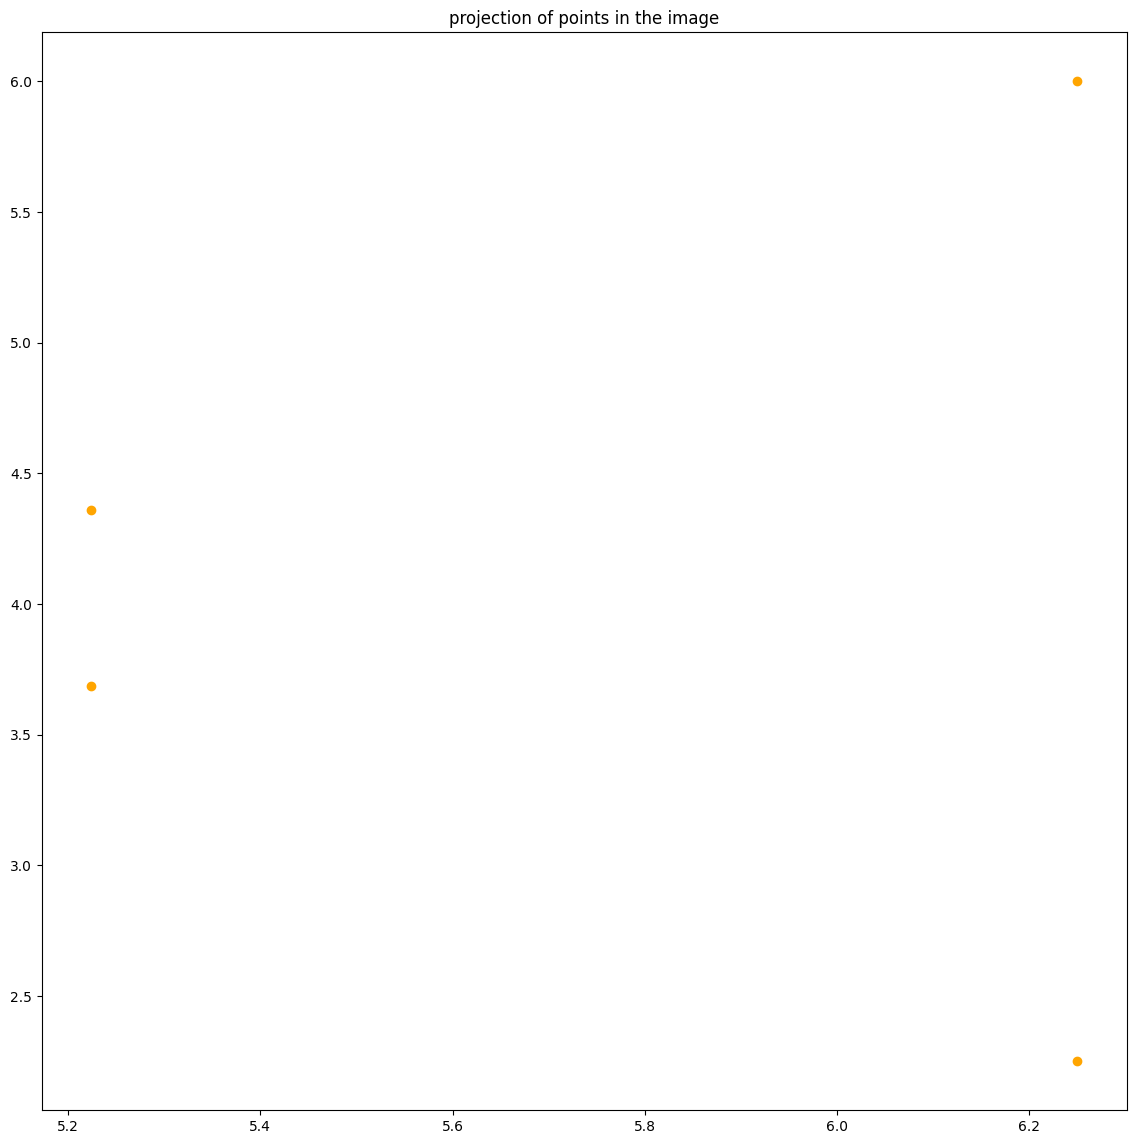

In [148]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)

for i in range(n_points):
    ax.scatter(*projections.T[i], color="orange")
    
ax.set_title("projection of points in the image")

# Perform Direct Linear Calibration

## Create the algebraic matrix A and find m

In [149]:
# compute the algebraic matrix A
A = create_algebraic_matrix(rand_points, projections)

# compute At x A
A_ = np.matmul(A.T, A)
# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
m = eigenvectors[:, 11]

# reshape m back to a matrix
M = m.reshape(3, 4)

## Compute predictions from the calibrated matrix M

In [150]:
predictions = compute_world2img_projection(rand_points, M, is_homogeneous=False)

D:\Workspace\Repos\Ship-Collision\module\utils.py:342: RuntimeWarning: invalid value encountered in divide
  h_points_i[0, :] = h_points_i[0, :] / h_points_i[2, :]
D:\Workspace\Repos\Ship-Collision\module\utils.py:343: RuntimeWarning: invalid value encountered in divide
  h_points_i[1, :] = h_points_i[1, :] / h_points_i[2, :]


## plot predictions and the groundtruth

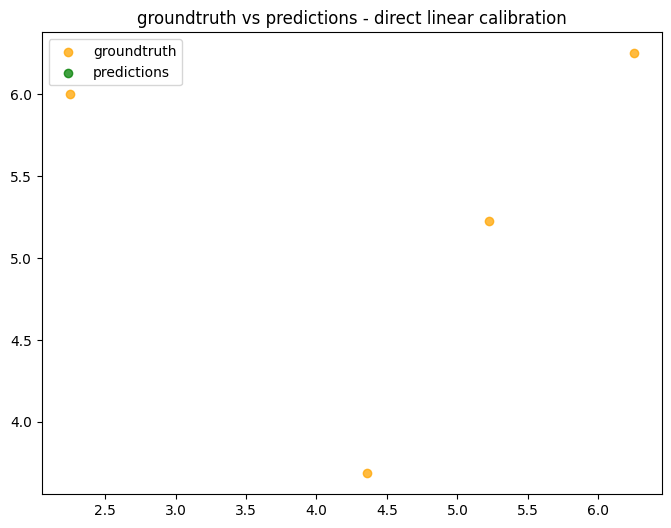

In [151]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""
        
    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(*predictions.reshape(-1, 2)[i], color="green", alpha=0.75, label=g_label)
    
ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()

# Optimizing wrt Geometric Error

In [152]:
from scipy.optimize import minimize

In [153]:
result = minimize(geometric_error, m, args=(rand_points, projections))

D:\Workspace\Repos\Ship-Collision\module\utils.py:378: RuntimeWarning: invalid value encountered in scalar divide
  u_ = u_ / d
D:\Workspace\Repos\Ship-Collision\module\utils.py:379: RuntimeWarning: invalid value encountered in scalar divide
  v_ = v_ / d
D:\Workspace\Repos\Ship-Collision\module\utils.py:378: RuntimeWarning: divide by zero encountered in scalar divide
  u_ = u_ / d
D:\Workspace\Repos\Ship-Collision\module\utils.py:379: RuntimeWarning: divide by zero encountered in scalar divide
  v_ = v_ / d


In [154]:
M_ = result.x.reshape(3, 4)

In [155]:
predictions_v2 = compute_world2img_projection(rand_points, M_, is_homogeneous=False)

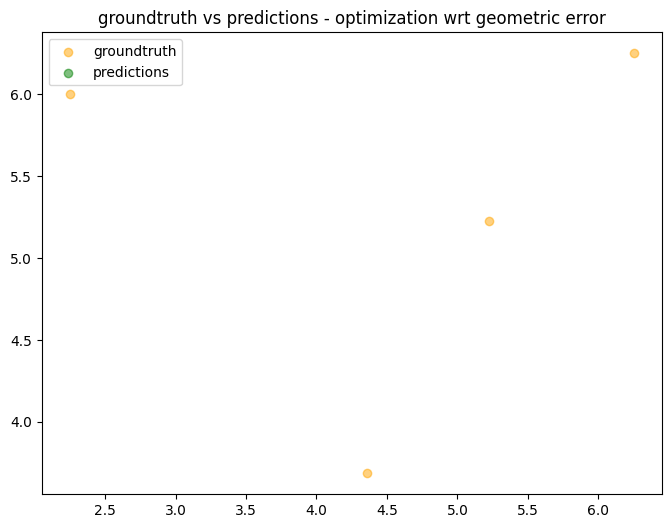

In [156]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""
        
    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.5, label=o_label)
    ax.scatter(*predictions_v2.reshape(-1, 2)[i], color="green", alpha=0.5, label=g_label)
    
ax.set_title("groundtruth vs predictions - optimization wrt geometric error")
ax.legend()

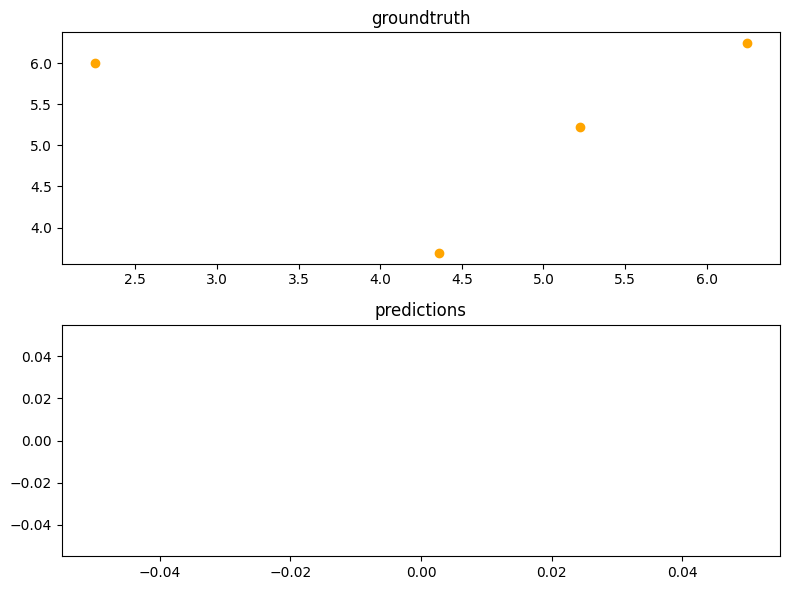

In [157]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

for i in range(n_points):
        
    axes[0].scatter(*projections.reshape(-1, 2)[i], color="orange", label=o_label)
    axes[1].scatter(*predictions_v2.reshape(-1, 2)[i], color="green", label=g_label)
    
axes[0].set_title("groundtruth")
axes[1].set_title("predictions")

plt.tight_layout()